# Results
Como não foi realizado nenhum tunning, seleção de variávies, ajuste de missings, o conjunto de validação esta sendo utilizado como conjunto de teste, então todas as comparações de resultados serão realizadas em cima desse conjunto.  

In [9]:
import pandas as pd
import pickle
import sys

sys.path.append('../')
from src.utils.modeling import get_metrics

pd.set_option('display.max_columns', None)

## Avaliação de Overfitting
Esta avaliação só faz sentido para modelos tabulares

In [12]:
df_train_lag = pd.read_parquet('../data/lag/full_train.parquet.gzip')
df_valid_lag = pd.read_parquet('../data/lag/full_valid.parquet.gzip')

In [13]:
df_train_lag = df_train_lag[df_train_lag['PULocationID'].isin([163, 79])].reset_index(drop=True)
df_valid_lag = df_valid_lag[df_valid_lag['PULocationID'].isin([163, 79])].reset_index(drop=True)

In [14]:
df_train_lag['year_month_day_hour'] = pd.to_datetime(df_train_lag['year_month_day_hour'], format='%Y-%m-%d %H')
df_valid_lag['year_month_day_hour'] = pd.to_datetime(df_valid_lag['year_month_day_hour'], format='%Y-%m-%d %H')

In [15]:
dt = pickle.load(open('../models/models/dt_reg_with_lag.pkl', 'rb'))
lgbm = pickle.load(open('../models/models/lgbm_reg_with_lag.pkl', 'rb'))
arima = pickle.load(open('../models/models/arima_2locations.pkl', 'rb'))

In [23]:
get_metrics(
    [
        (dt, dt.feature_names_in_, 'with lag features', df_train_lag, df_valid_lag),
        (lgbm, lgbm.feature_names_in_, 'with lag features', df_train_lag, df_valid_lag),
        (arima, ['year_month_day_hour', 'PULocationID'], 'arima top8', df_valid_lag, df_valid_lag)
    ],
    df_train_lag,
    df_valid_lag,
    'qty_travels'
)


,model,desc,rmse_train,rmse_valid,diff_rmse,mae_train,mae_valid,diff_mae
0,Default,Default values mean + std,45.56 +- 58.67,49.60 +- 65.00,0.000000,45.56 +- 58.67,49.60 +- 65.00,0.000000
1,<class 'sklearn.tree._classes.DecisionTreeRegr...,with lag features,14.192304,18.913203,-4.720899,7.944831,10.246565,-2.301734
2,<class 'lightgbm.sklearn.LGBMRegressor'>,with lag features,6.915985,16.770502,-9.854517,4.695189,9.229771,-4.534582
3,<class 'src.utils.modeling.TemporalModels'>,arima top8,35.287486,35.287486,0.000000,19.187945,19.187945,0.000000


Avaliando overfitting entre os modelos tabulares vemos uma diferença relevante entre o conjunto de treino e validação, indicando possível overfitting. Para redução desse possível overfitting podemos seguir com uma otimização de hiperparametros, penalizando soluções com grandes diferenças entre treino e validação, ou então adiconando mais dados ao treinamento.  

Verificar erro do arima aos finais de semana, tentar treinar só com os dias da semana.  
Tentar prever 2/3 horas    
Tentar trazer informação espacial, trazendo dados dos vizinhos  
 - Provavelmente vou ter problemas com tamanho da área, fazer razão?  
 - Comparar o valor do vizinho com valor histórico  
 - Trabalahr no texto, explicar os dados, explicar problema da previsão, problema de demanda 

## Performance no Conjunto de validação

In [17]:
df_valid_lag['pred_dt'] = dt.predict(df_valid_lag[dt.feature_names_in_])
df_valid_lag['pred_lgbm'] = lgbm.predict(df_valid_lag[lgbm.feature_names_in_])
df_valid_lag['pred_arima'] = arima.predict(df_valid_lag[['year_month_day_hour', 'PULocationID']])

In [19]:
df_valid_lag.head()

,year_month_day_hour,PULocationID,Maximum_max,Minimum_max,passenger_count_sum,day_of_week_max,period_of_day_dawn_sum,period_of_day_morning_sum,period_of_day_afternoon_sum,period_of_day_evening_sum,qty_travels,year_month_day_hour_l1,year_month_day_hour_l2,year_month_day_hour_l3,Maximum_max_l3,Minimum_max_l3,passenger_count_sum_l3,day_of_week_max_l3,period_of_day_dawn_sum_l3,period_of_day_morning_sum_l3,period_of_day_afternoon_sum_l3,period_of_day_evening_sum_l3,qty_travels_l3,Maximum_max_l2,Minimum_max_l2,passenger_count_sum_l2,day_of_week_max_l2,period_of_day_dawn_sum_l2,period_of_day_morning_sum_l2,period_of_day_afternoon_sum_l2,period_of_day_evening_sum_l2,qty_travels_l2,Maximum_max_l1,Minimum_max_l1,passenger_count_sum_l1,day_of_week_max_l1,period_of_day_dawn_sum_l1,period_of_day_morning_sum_l1,period_of_day_afternoon_sum_l1,period_of_day_evening_sum_l1,qty_travels_l1,pred_dt,pred_lgbm,pred_arima
0,2024-02-01 00:00:00,79,42.0,34.0,88.0,3,67,0,0,0,1.0,2024-01-31 23,2024-01-31 22,2024-01-31 21,42.0,34.0,16.0,3.0,15.0,0.0,0.0,0.0,1.0,42.0,34.0,30.0,3.0,25.0,0.0,0.0,0.0,2.0,42.0,34.0,44.0,3.0,34.0,0.0,0.0,0.0,2.0,4.142857,2.600247,17.515598
1,2024-02-01 00:00:00,163,42.0,34.0,60.0,3,52,0,0,0,44.0,2024-01-31 23,2024-01-31 22,2024-01-31 21,42.0,34.0,7.0,3.0,8.0,0.0,0.0,0.0,15.0,42.0,34.0,15.0,3.0,13.0,0.0,0.0,0.0,16.0,42.0,34.0,17.0,3.0,14.0,0.0,0.0,0.0,34.0,22.850000,61.249453,69.667311
2,2024-02-01 01:00:00,79,42.0,34.0,44.0,3,34,0,0,0,2.0,2024-02-01 00,2024-01-31 23,2024-01-31 22,42.0,34.0,7.0,3.0,9.0,0.0,0.0,0.0,2.0,42.0,34.0,16.0,3.0,15.0,0.0,0.0,0.0,1.0,42.0,34.0,30.0,3.0,25.0,0.0,0.0,0.0,2.0,1.000000,2.326698,4.168354
3,2024-02-01 01:00:00,163,42.0,34.0,17.0,3,14,0,0,0,34.0,2024-02-01 00,2024-01-31 23,2024-01-31 22,42.0,34.0,8.0,3.0,8.0,0.0,0.0,0.0,12.0,42.0,34.0,7.0,3.0,8.0,0.0,0.0,0.0,15.0,42.0,34.0,15.0,3.0,13.0,0.0,0.0,0.0,16.0,22.850000,31.123239,14.705680
4,2024-02-01 02:00:00,79,42.0,34.0,30.0,3,25,0,0,0,2.0,2024-02-01 01,2024-02-01 00,2024-01-31 23,42.0,34.0,14.0,3.0,11.0,0.0,0.0,0.0,3.0,42.0,34.0,7.0,3.0,9.0,0.0,0.0,0.0,2.0,42.0,34.0,16.0,3.0,15.0,0.0,0.0,0.0,1.0,1.000000,2.243135,3.396810


/tmp/ipykernel_144534/2127961894.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_valid_lag[col] for col in ['qty_travels', 'pred_dt', 'pred_lgbm', 'pred_arima']], labels=['Esperado', 'Decision Tree', 'Boosting', 'ARIMA'])


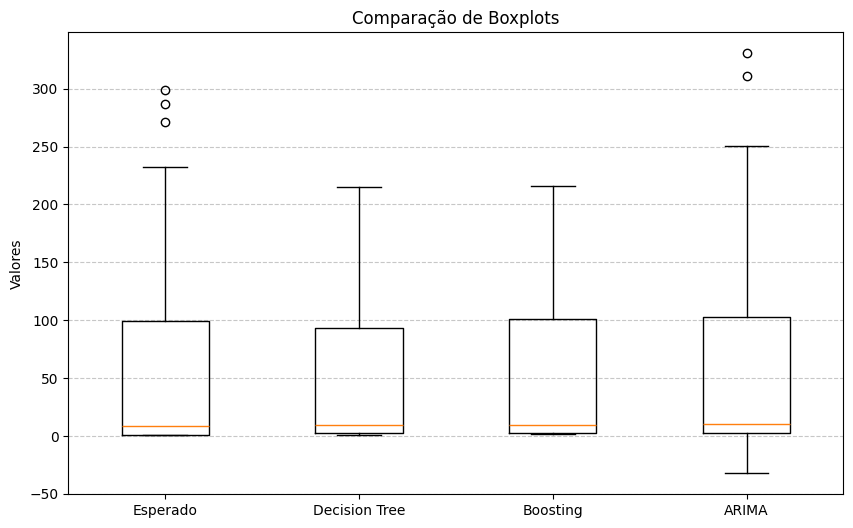

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criar o boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([df_valid_lag[col] for col in ['qty_travels', 'pred_dt', 'pred_lgbm', 'pred_arima']], labels=['Esperado', 'Decision Tree', 'Boosting', 'ARIMA'])

# Configurações do gráfico
plt.title("Comparação de Boxplots")
plt.ylabel("Valores")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Exibir o gráfico
plt.show()

In [ ]:
df_valid_lag